# FEATURE EXTRACTION ANALYSIS


The goal of feature extraction is to transform raw data into a reduced set of informative characteristics, or "features," that capture essential information from the data, often in a lower-dimensional space.

Given a set of input data points $X = {x_0, x_1, ..., x_n}$, where each $x \in \mathbb{R}^D$, the objective is to define a function $f(x, \theta)$ that maps each input $x$ to a new representation $z = f(x, \theta)$, with $z \in \mathbb{R}^d$. Typically, we aim for $d \ll D$, allowing for a more compact and efficient representation of the data. Here, $\theta$ represents the parameters of the model optimized to capture essential features in a reduced dimension.

## Example 1:  MNIST Digits

### Loading the MNIST dataset

In [1]:
import gzip
import os
import numpy as np
import struct


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        _, _ = struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        _, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(num, rows*cols)

    return images, labels

In [2]:
# Load the dataset
mnist_path = '../supplemental_material/MNIST' 
X_train, y_train = load_mnist(mnist_path, kind='train')
X_test, y_test = load_mnist(mnist_path, kind='t10k')

print(f"Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Training set shape: (60000, 784), Training labels shape: (60000,)
Test set shape: (10000, 784), Test labels shape: (10000,)


### MLP as feature extractor

In [3]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, return_features=False):
        out = self.fc1(x)
        out = self.relu(out)
        features = self.fc2(out)
        if return_features:
            return features  # Return features before final activation
        out = self.sigmoid(features)
        return out

In [4]:
# Convert the data to PyTorch tensors and normalize it
X_train_tensor = torch.tensor(X_train, dtype=torch.float32) / 255.0  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32) / 255.0

In [5]:
model = MLP()
with torch.no_grad():
    test_features = model(X_test_tensor, return_features=True)

print(f"Extracted feature shape for training set: {test_features.shape}")

Extracted feature shape for training set: torch.Size([10000, 10])


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_features(features, labels):
    """
    Reduces precomputed features to 2D using UMAP and plots them with colors by label.

    Parameters:
        features (np.array): Precomputed feature vectors.
        labels (np.array): Labels for the data points to color the plot.
    """
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=features[:, 0], 
        y=features[:, 1], 
        hue=labels, 
        palette="tab10", 
        s=30, 
        alpha=0.7, 
        edgecolor='k', 
        legend="full"
    )
    plt.title("2D Visualization of Features using UMAP")
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.legend(title="Label", loc="best")
    plt.show()

In [7]:
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=1, random_state=42)
umap_embedding = reducer.fit_transform(test_features)

c:\Users\rodani\OneDrive - Area Science Park\Documenti\GitHub\Introduction-Statistical-Data-Analysis-Machine-Learning\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


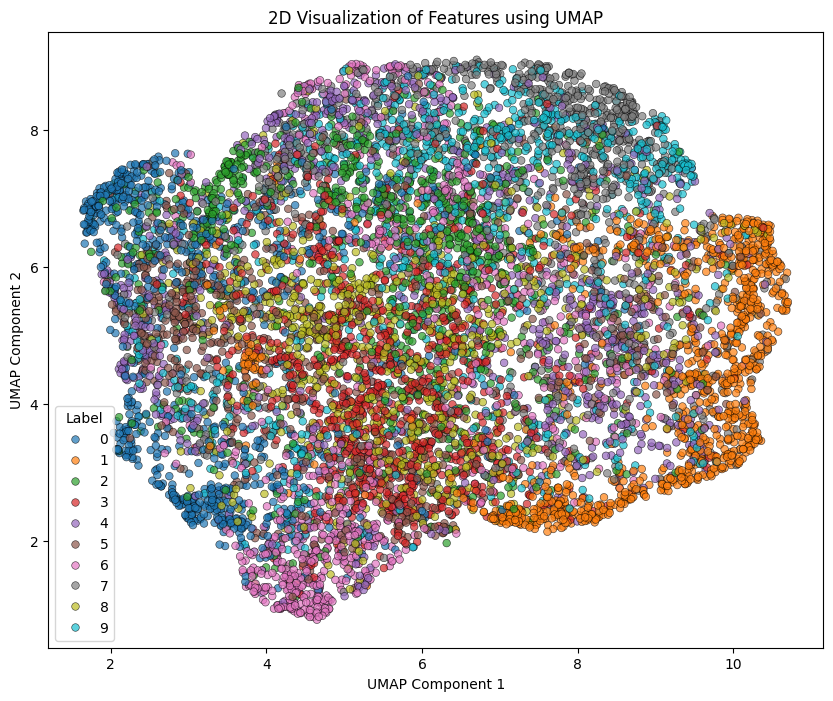

In [8]:
plot_features(umap_embedding, y_test)

Loading model weights from ..\classification\data\weights\MLP\MNIST.pth


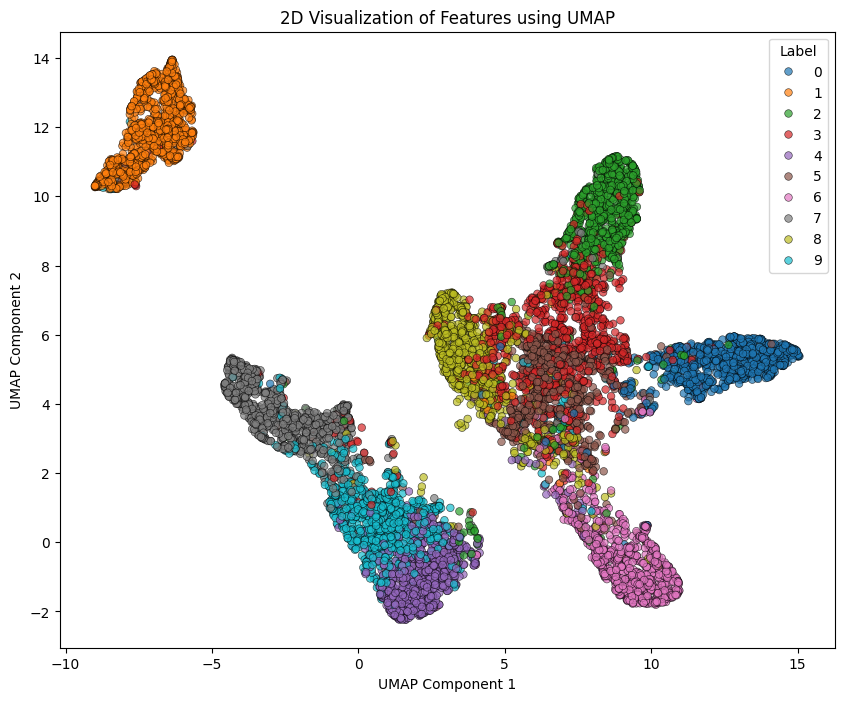

In [9]:
# load the model weights
weights = os.path.join("..","classification","data", "weights", "MLP","MNIST.pth")
print(f"Loading model weights from {weights}")
model.load_state_dict(torch.load(weights,weights_only=True))
model.eval()
with torch.no_grad():
    test_features = model(X_test_tensor, return_features=True)

umap_embedding = reducer.fit_transform(test_features)
plot_features(umap_embedding, y_test)

### LeNet as feature extractor

In [10]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 output units for the 10 classes

    def forward(self, x, return_features=False):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        features = torch.relu(self.fc2(x))
        if return_features:
            return features  # Return features before the final layer
        x = self.fc3(features)
        return x

In [13]:
model = LeNet5()
model.eval()
X_test, y_test = load_mnist(mnist_path, kind='t10k')
X_test = X_test.reshape(-1, 1, 28, 28).astype(np.float32)
X_test_tensor = torch.tensor(X_test)
with torch.no_grad():
    test_features = model(X_test_tensor, return_features=True)

print(f"Extracted feature shape for training set: {test_features.shape}")

Extracted feature shape for training set: torch.Size([10000, 84])


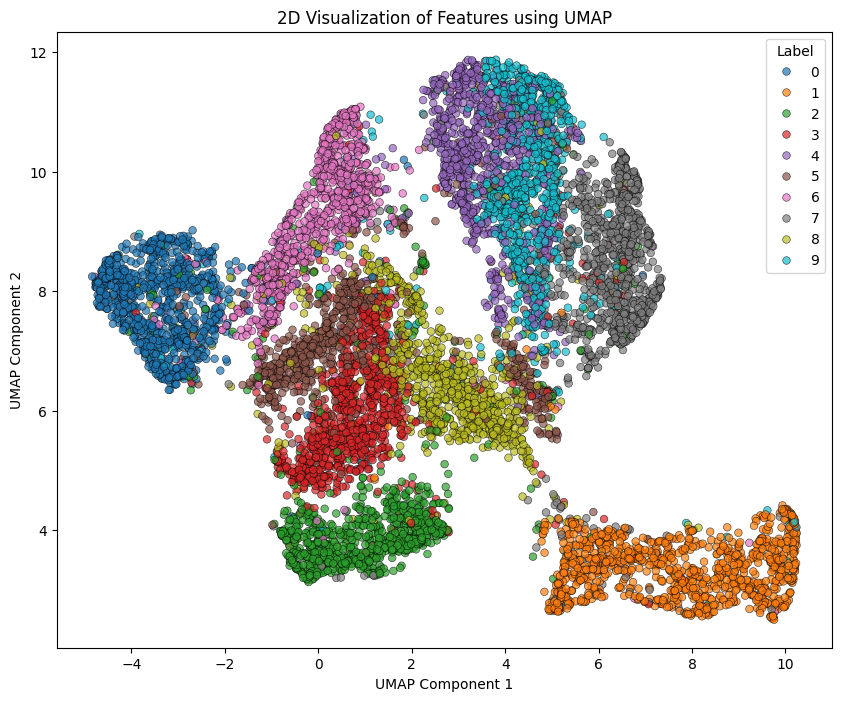

In [14]:
umap_embedding = reducer.fit_transform(test_features)
plot_features(umap_embedding, y_test)

Loading model weights from ..\classification\data\weights\LeNet5\MNIST.pth


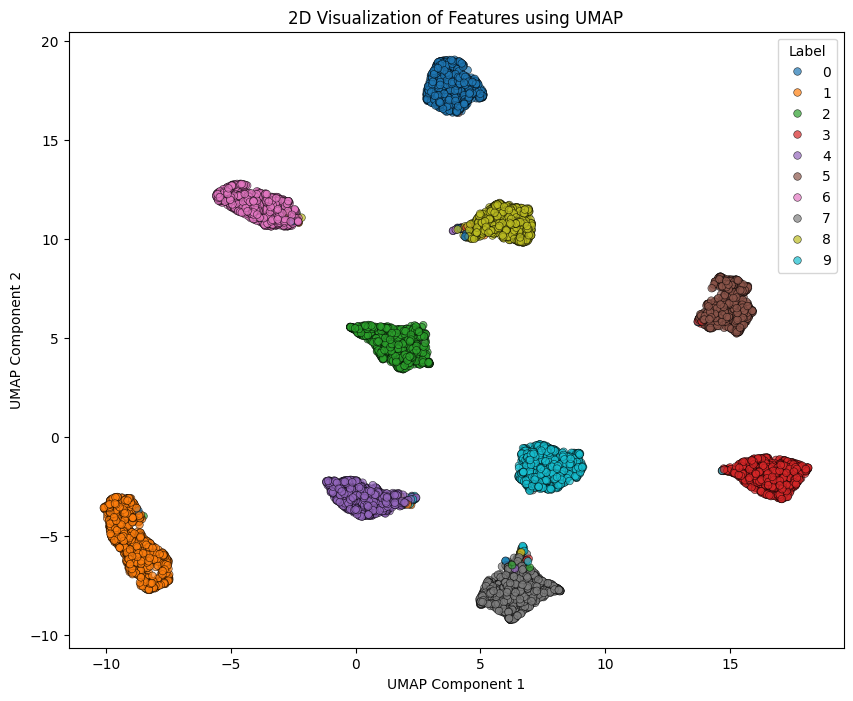

In [15]:
# load the model weights
weights = os.path.join("..","classification","data", "weights", "LeNet5","MNIST.pth")
print(f"Loading model weights from {weights}")
model.load_state_dict(torch.load(weights,weights_only=True))
model.eval()
with torch.no_grad():
    test_features = model(X_test_tensor, return_features=True)

umap_embedding = reducer.fit_transform(test_features)
plot_features(umap_embedding, y_test)

### UMAP visualization on MNIST 

Head to [UMAP visualization](https://grantcuster.github.io/umap-explorer/) to visually explorer the MNIST dataset in a 2D UMAP projection.

> Credit: Grant Custer https://github.com/GrantCuster/umap-explorer